## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Video

---
## Part I. Compute the camera calibration using chessboard images

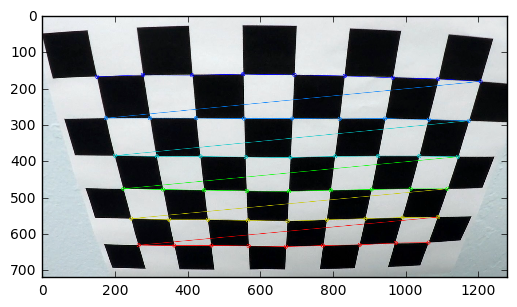

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

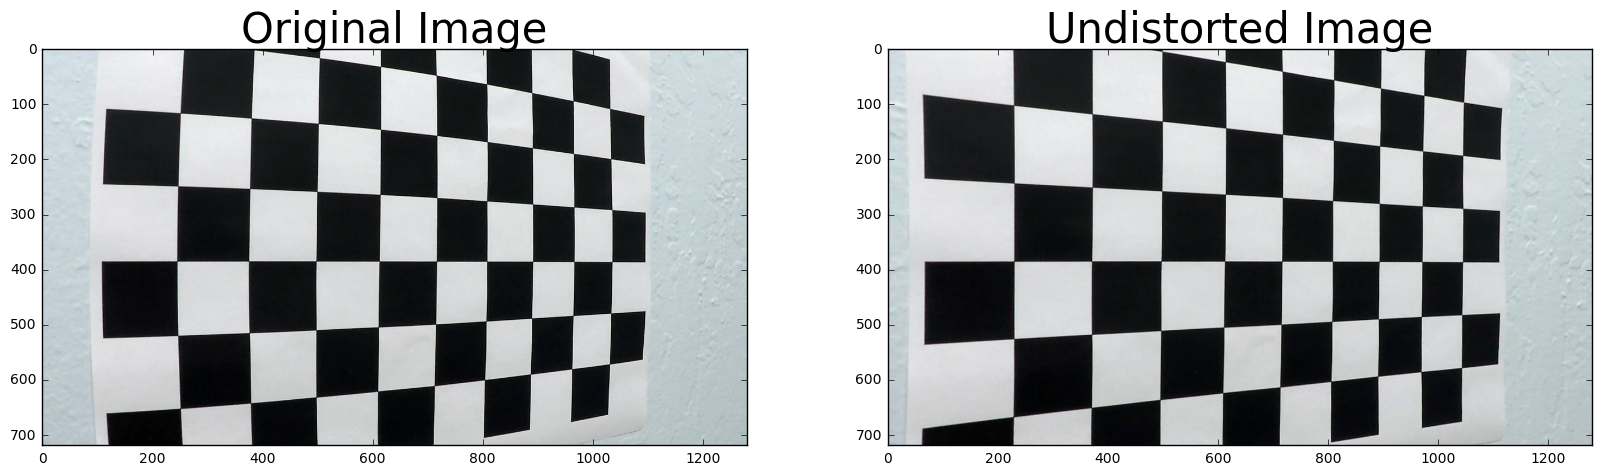

In [2]:
raw_img = cv2.imread('camera_cal/calibration5.jpg')
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
# show image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
# plt.savefig('output_images/calibration.png')

## Part II. Apply a distortion correction to raw images

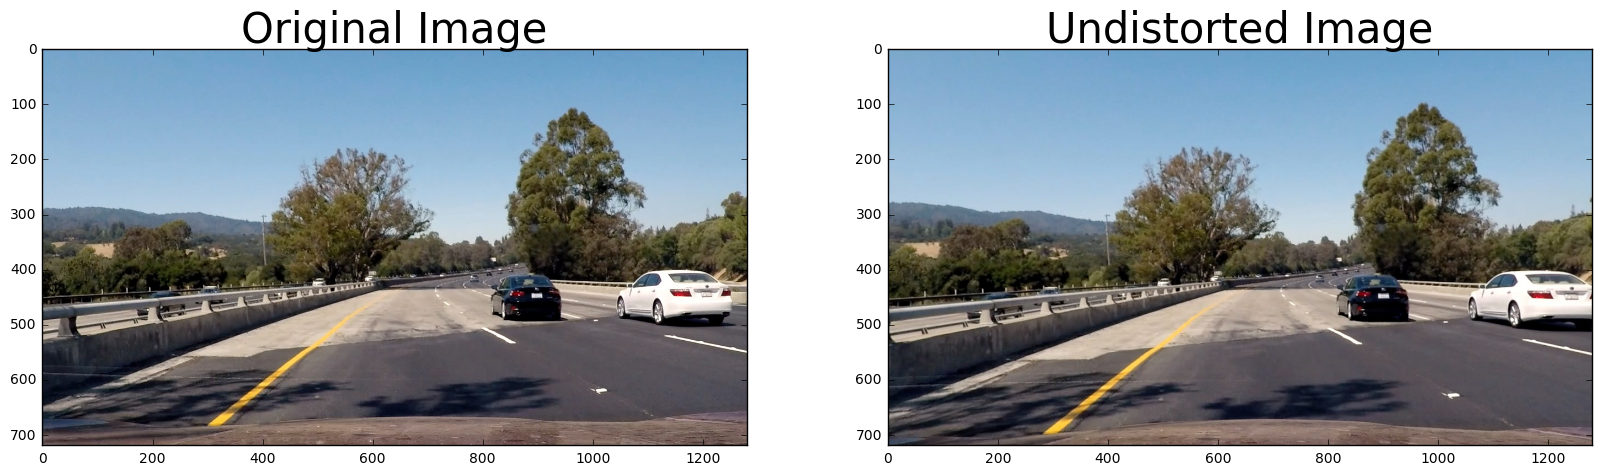

In [3]:
raw_img = cv2.imread('test_images/test4.jpg')
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
# show image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
# plt.savefig('output_images/undistort_output.png')

## Part III. Use color transforms, gradients, etc., to create a thresholded binary image

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary

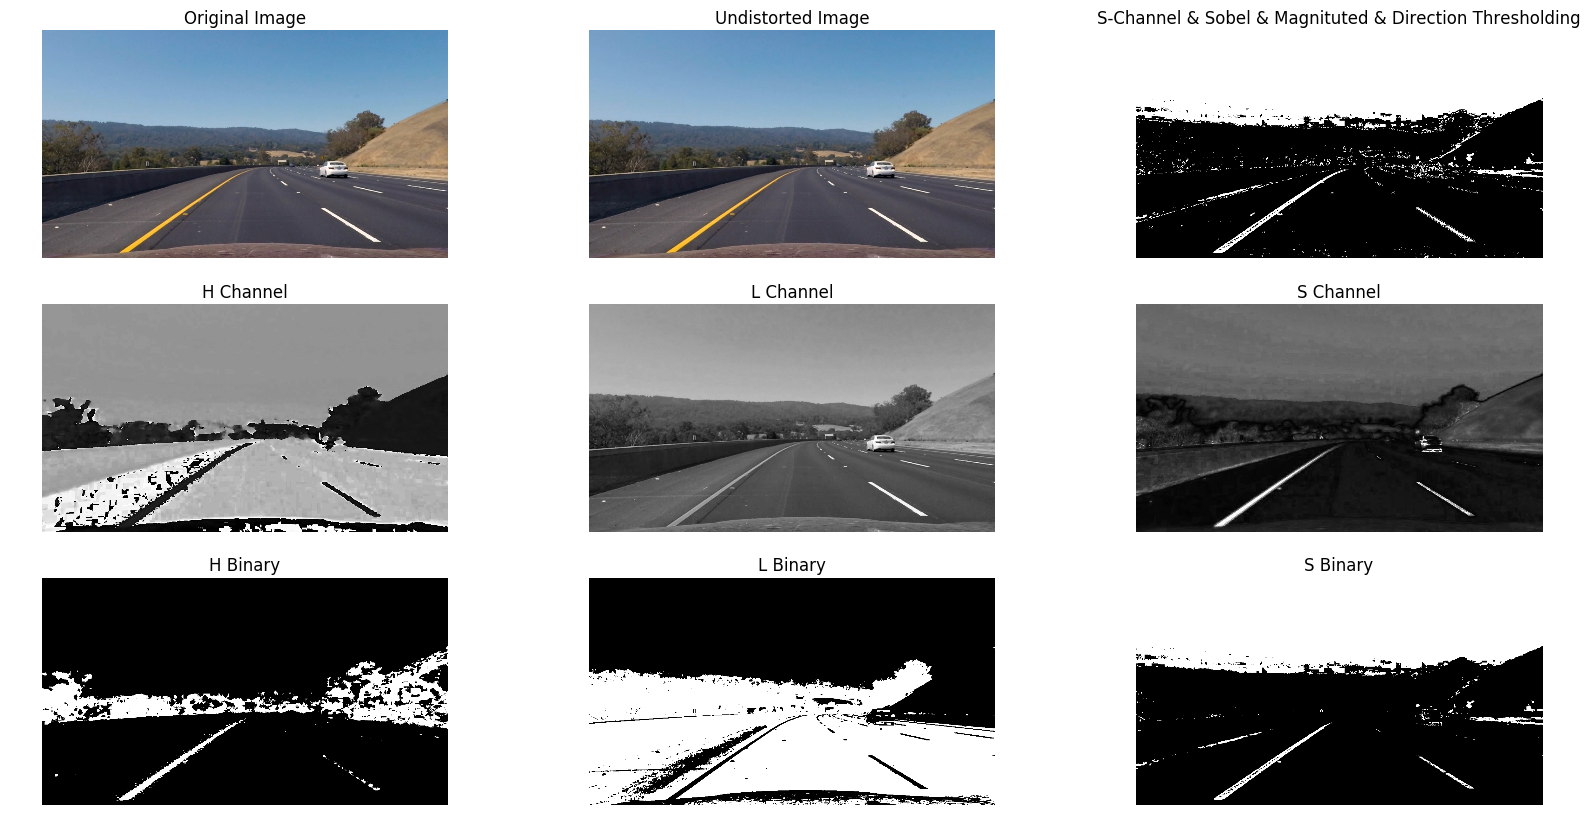

In [5]:
img = cv2.imread('test_images/test3.jpg')
### undistort
img = cv2.undistort(img, mtx, dist, None, mtx)
### threshold
ksize=3
# Sobel
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
# Magnituted of the Gradient
mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
# Direction of the Gradient
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# combine the thresholding functions of Sobel, Magnituted, Direction
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# HLS
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
binary_H = np.zeros_like(H)
binary_H[(H > 15) & (H < 100)] = 1
binary_L = np.zeros_like(L)
binary_L[(L > 15) & (L < 100)] = 1
binary_S = np.zeros_like(S)
binary_S[(S > 90) & (S < 255)] = 1
# combine S
combined_S = np.zeros_like(dir_binary)
combined_S[(combined == 1) | (binary_S == 1)] = 1
### show image
images = []
images.append([img, 'Original Image', 'BGR'])
images.append([img, 'Undistorted Image', 'BGR'])
# images.append([combined, 'Sobel & Magnituted & Direction Thresholding', 'gray'])
images.append([combined_S, 'S-Channel & Sobel & Magnituted & Direction Thresholding', 'gray'])
images.append([H, 'H Channel', 'gray'])
images.append([L, 'L Channel', 'gray'])
images.append([S, 'S Channel', 'gray'])
images.append([binary_H, 'H Binary', 'gray'])
images.append([binary_L, 'L Binary', 'gray'])
images.append([binary_S, 'S Binary', 'gray'])

plt.subplots(3, 3, figsize=(20,10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(images[i][1])
    plt.axis('off')
    if images[i][2] == 'BGR':
        plt.imshow(cv2.cvtColor(images[i][0], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(images[i][0], cmap='gray')
# plt.savefig('output_images/thresholding.png')

## Part IV. Apply a perspective transform to rectify binary image ("birds-eye view")

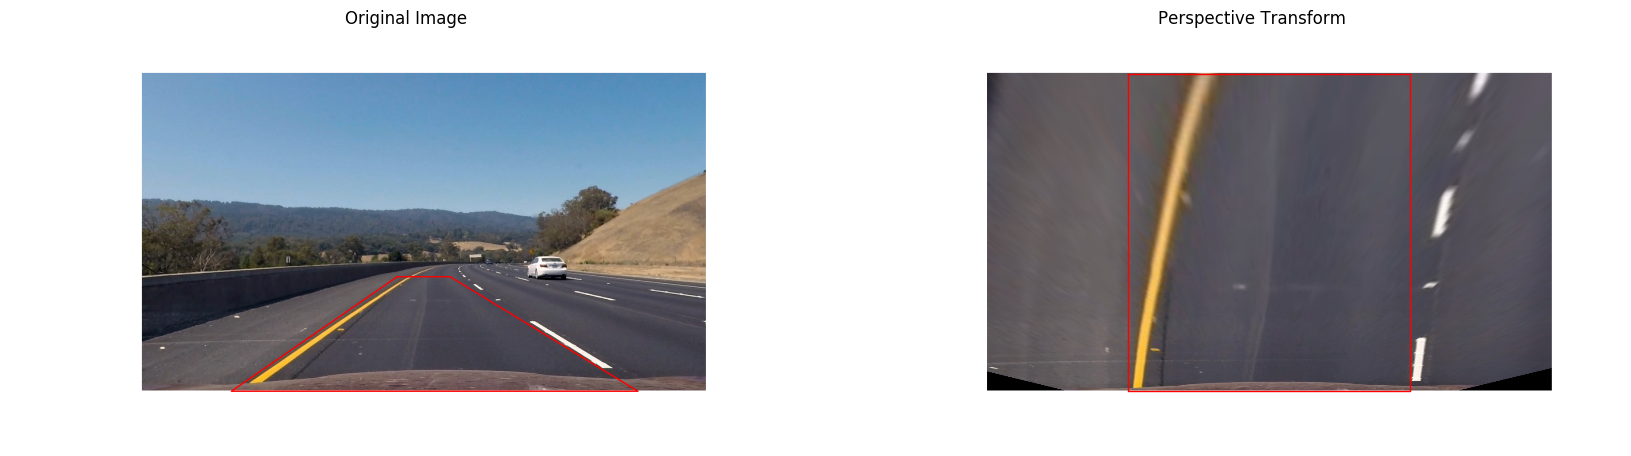

In [6]:
img_size = (1280, 720)
src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.subplots(1, 2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.plot([src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]], 
         [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]], 'r-')
plt.subplot(1, 2, 2)
plt.title('Perspective Transform')
plt.axis('off')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.plot([dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]], 
         [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]], 'r-')
# plt.savefig('output_images/perspective.png')

## Part V. Detect lane pixels and fit to find the lane boundary

In [7]:
class Line():
    def __init__(self, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, height):
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        # Extract left and right line pixel positions
        self.leftx = nonzerox[self.left_lane_inds]
        self.lefty = nonzeroy[self.left_lane_inds] 
        self.rightx = nonzerox[self.right_lane_inds]
        self.righty = nonzeroy[self.right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        self.ploty = np.linspace(0, height-1, height )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

In [8]:
def detect_lane_init(binary_warped, nonzerox, nonzeroy, margin=100):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
    #     cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    #     cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    line = Line(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped.shape[0])
    return line

/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

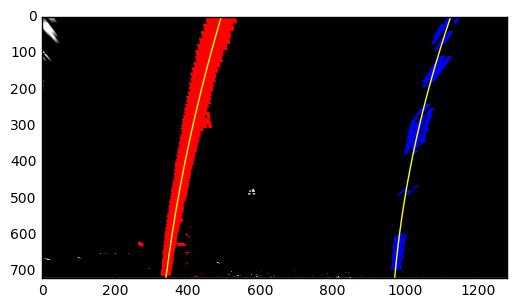

In [9]:
binary_warped = cv2.warpPerspective(combined_S, M, img_size, flags=cv2.INTER_LINEAR)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
line = detect_lane_init(binary_warped, nonzerox, nonzeroy)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))

out_img[nonzeroy[line.left_lane_inds], nonzerox[line.left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[line.right_lane_inds], nonzerox[line.right_lane_inds]] = [0, 0, 1]
plt.imshow(out_img)
plt.plot(line.left_fitx, line.ploty, color='yellow')
plt.plot(line.right_fitx, line.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [10]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def detect_lane_next(binary_warped, line, nonzerox, nonzeroy, margin=100):
    left_lane_inds = ((nonzerox > (line.left_fit[0]*(nonzeroy**2) + line.left_fit[1]*nonzeroy + line.left_fit[2] - margin)) & (nonzerox < (line.left_fit[0]*(nonzeroy**2) + line.left_fit[1]*nonzeroy + line.left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (line.right_fit[0]*(nonzeroy**2) + line.right_fit[1]*nonzeroy + line.right_fit[2] - margin)) & (nonzerox < (line.right_fit[0]*(nonzeroy**2) + line.right_fit[1]*nonzeroy + line.right_fit[2] + margin)))  
    newline = Line(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped.shape[0])
    return newline
line = detect_lane_next(binary_warped, line, nonzerox, nonzeroy, margin=50)

(720, 0)

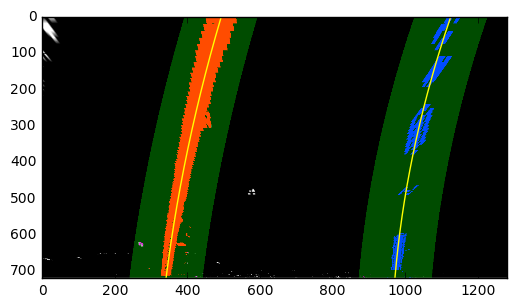

In [11]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[line.left_lane_inds], nonzerox[line.left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[line.right_lane_inds], nonzerox[line.right_lane_inds]] = [0, 0, 1]
margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([line.left_fitx-margin, line.ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([line.left_fitx+margin, line.ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([line.right_fitx-margin, line.ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([line.right_fitx+margin, line.ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 1, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 1, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(line.left_fitx, line.ploty, color='yellow')
plt.plot(line.right_fitx, line.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
# plt.savefig('output_images/color_fit_lines.png')

## Part VI. Determine the curvature of the lane and vehicle position with respect to center

In [12]:
def calc_curverad_vehicle(img, line):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(line.lefty*ym_per_pix, line.leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(line.righty*ym_per_pix, line.rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(line.ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    pst = ((line.rightx[0] + line.leftx[0]) / 2 - img.shape[1] / 2) * xm_per_pix
    return left_curverad, right_curverad, pst

left_curverad, right_curverad, pst = calc_curverad_vehicle(img, line)

print('Radius of curvature: %.3f(M), %.3f(M)' % (left_curverad, right_curverad))
print('Vehicle is %.3f(M) left of center' % pst)

Radius of curvature: 1397.656(M), 920.446(M)
Vehicle is 0.777(M) left of center


## Part VII. Warp the detected lane boundaries back onto the original image

In [13]:
def warp_back(img, Minv, binary_warped, line, nonzerox, nonzeroy):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([line.left_fitx, line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line.right_fitx, line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    color_warp[nonzeroy[line.left_lane_inds], nonzerox[line.left_lane_inds]] = [0, 0, 255]
    color_warp[nonzeroy[line.right_lane_inds], nonzerox[line.right_lane_inds]] = [255, 0, 0]
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    return result

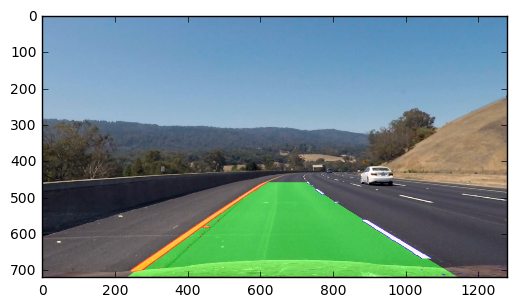

In [14]:
result = warp_back(img, Minv, binary_warped, line, nonzerox, nonzeroy)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Part VIII. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

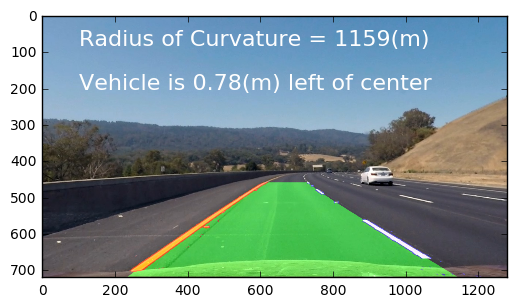

In [15]:
text1 = 'Radius of Curvature = %d(m)' % ((left_curverad + right_curverad) / 2)
text2 = 'Vehicle is %.2f(m) left of center' % pst
plt.text(100, 80, text1, color='white', fontsize=16)
plt.text(100, 200, text2, color='white', fontsize=16)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Part IX. Video

In [16]:
def threshold(img, ksize=3):
    # Sobel
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    # Magnituted of the Gradient
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
    # Direction of the Gradient
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    # combine the thresholding functions of Sobel, Magnituted, Direction
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary_S = np.zeros_like(S)
    binary_S[(S > 90) & (S < 255)] = 1
    # combine S
    combined_S = np.zeros_like(dir_binary)
    combined_S[(combined == 1) | (binary_S == 1)] = 1
    return combined_S

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
flag = True
curverad = []
position = []
def process_image(image):
    global flag, line
    img = cv2.undistort(image, mtx, dist, None, mtx)
    combined_threshold = threshold(img)
    binary_warped = cv2.warpPerspective(combined_threshold, M, img_size, flags=cv2.INTER_LINEAR)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     line = detect_lane_init(binary_warped, nonzerox, nonzeroy, margin=50)
    if flag:
        line = detect_lane_init(binary_warped, nonzerox, nonzeroy, margin=50)
        flag = False
    else:
        line = detect_lane_next(binary_warped, line, nonzerox, nonzeroy, margin=50)
    result = warp_back(img, Minv, binary_warped, line, nonzerox, nonzeroy)
    
    left_curverad, right_curvarad, pst = calc_curverad_vehicle(img, line)
    curverad.append((left_curverad + right_curverad) / 2)
    position.append(pst)
    
    text1 = 'Radius of Curvature = %d(m)' % (sum(curverad[-5:])/len(curverad[-5:]))
    text2 = 'Vehicle is %.2f(m) left of center' % (sum(position[-5:])/len(position[-5:]))
    
    cv2.putText(result, text1, (100,80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, text2, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),2,cv2.LINE_AA)
    return result

/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


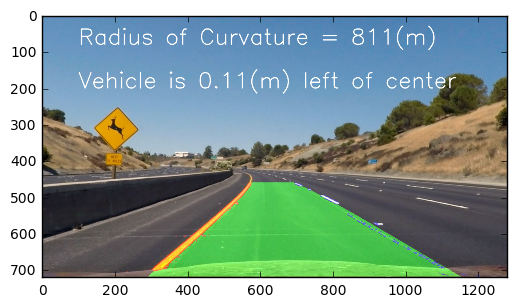

In [18]:
img = cv2.imread('test_images/test2.jpg')
result = process_image(img)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [19]:
video1 = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
flag = True
video1_clip = clip1.fl_image(process_image)
%time video1_clip.write_videofile(video1, audio=False)

/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_video_result.mp4
----------------------------------------

Writing video into project_video_result.mp4


/home/lengly/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
100%|██████████| 1210/1210 [05:37<00:00,  3.65it/s]


Done writing video in project_video_result.mp4 !
Your video is ready !
CPU times: user 7min 31s, sys: 24.4 s, total: 7min 55s
Wall time: 5min 37s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1))